In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm, multivariate_normal

In [2]:
dataset = pd.read_csv('UAS_ML2021_DATASET02.csv')
dataset

,Atribut_01,Atribut_02
0,67.062924,176.086355
1,68.804094,178.388669
2,60.930863,170.284496
3,59.733843,168.691992
4,65.431230,173.763679
...,...,...
495,59.976983,169.679741
496,66.423814,174.625574
497,53.604698,161.919208
498,50.433644,160.794875


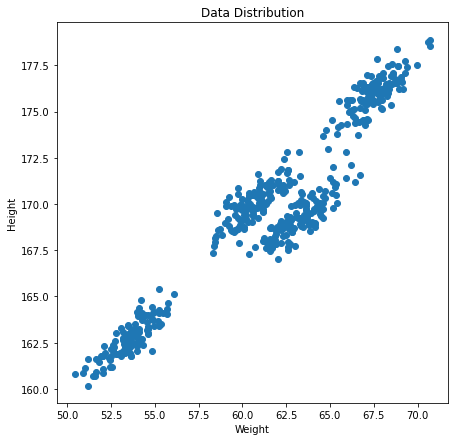

In [3]:
plt.figure(figsize=(7,7))
plt.scatter(dataset["Atribut_01"],dataset["Atribut_02"])
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Data Distribution')
plt.show()

K =  3


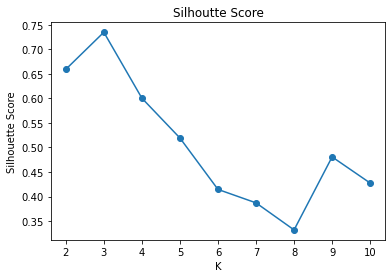

In [4]:
metric = []
K = 10
for k in range(2, K+1):
    scaler = StandardScaler()
    dataset = scaler.fit_transform(dataset)
    GMM = GaussianMixture(n_components=k, n_init=20, init_params='kmeans')
    cluster = GMM.fit_predict(dataset)
    metric.append(silhouette_score(dataset, cluster, metric = 'euclidean'))

plt.title('Silhoutte Score')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.scatter(range(2,11), metric)
plt.plot(range(2,11), metric)

print("K = ", metric.index(max(metric))+2)


In [5]:
def Trace(cov_list):
    list_sigma=[]
    for mat in cov_list :
        list_sigma.append(np.trace(mat)/mat.shape[0])
    return list_sigma

In [6]:
class EM2(object):
    def __init__(self, X, k=3):
        X = np.asarray(X)
        self.m, self.n = X.shape
        self.data = X.copy()
        self.k = k
    def _init(self):
        self.mean_arr = np.asmatrix(np.random.random((self.k, self.n)))
        self.sigma_arr = np.array([np.asmatrix(np.identity(self.n)) for i in range(self.k)])
        self.phi = np.ones(self.k)/self.k
        self.w = np.asmatrix(np.empty((self.m, self.k), dtype=float))
    def fit(self, tol=1e-4):
        self._init()
        num_iters = 0
        ll = 1
        previous_ll = 0
        while(ll-previous_ll > tol):
            previous_ll = self.loglikelihood()
            self._fit()
            num_iters += 1
            ll = self.loglikelihood()
            print('Iteration %d: log-likelihood is %.6f'%(num_iters, ll))
        print('Terminate at %d-th iteration:log-likelihood is %.6f'%(num_iters, ll))
        print()
        print("Means vector:", self.mean_arr)
        print()
        print("Covariances vector:",self.sigma_arr,"|","sigma list :", Trace(self.sigma_arr))
        print()
        print("Weight vector :", self.phi)
    def loglikelihood(self):
        ll = 0
        for i in range(self.m):
            tmp = 0
            for j in range(self.k):
                tmp += sp.stats.multivariate_normal.pdf(self.data[i, :],
                                                    self.mean_arr[j, :].A1,
                                                    self.sigma_arr[j, :])*\
                self.phi[j]
                ll += np.log(tmp)
        return ll
    def _fit(self):
        self.e_step()
        self.m_step()
    def e_step(self):
        for i in range(self.m):
            den = 0
            for j in range(self.k):
                num = sp.stats.multivariate_normal.pdf(self.data[i, :],
                                                       self.mean_arr[j].A1,
                                                       self.sigma_arr[j])*\
                self.phi[j]
                den += num
                self.w[i, j] = num
            self.w[i, :] /= den
            assert self.w[i, :].sum() - 1 < 1e-4
    def m_step(self):
        for j in range(self.k):
            const = self.w[:, j].sum()
            self.phi[j] = 1/self.m * const
            _mu_j = np.zeros(self.n)
            _sigma_j = np.zeros((self.n, self.n))
            for i in range(self.m):
                _mu_j += (self.data[i, :] * self.w[i, j])
                _sigma_j += self.w[i, j] * ((self.data[i, :]-self.mean_arr[j, :]).T * (self.data[i, :]-self.mean_arr[j, :]))
            self.mean_arr[j] = _mu_j / const
            self.sigma_arr[j] = _sigma_j / const

In [7]:
gmm = EM2(dataset)
gmm.fit()

Iteration 1: log-likelihood is -3610.772124
Iteration 2: log-likelihood is -3211.758437
Iteration 3: log-likelihood is -3223.659221
Terminate at 3-th iteration:log-likelihood is -3223.659221

Means vector: [[ 0.21358943  0.18243423]
 [ 0.1847449   0.19603243]
 [-0.37093073 -0.35416244]]

Covariances vector: [[[0.80638142 0.77637747]
  [0.77637747 0.84616968]]

 [[0.91805823 0.89933329]
  [0.89933329 0.9627375 ]]

 [[1.04406865 0.97690245]
  [0.97690245 0.98366209]]] | sigma list : [0.8262755488747306, 0.9403978645887986, 1.0138653690704995]

Weight vector : [0.31096445 0.34042476 0.3486108 ]


Converged or not:  True
Means:  [[-1.47731815 -1.40636714]
 [ 0.13659756  0.02904145]
 [ 1.20321491  1.34715995]]
phi:  [0.25000092 0.49978485 0.25021423]


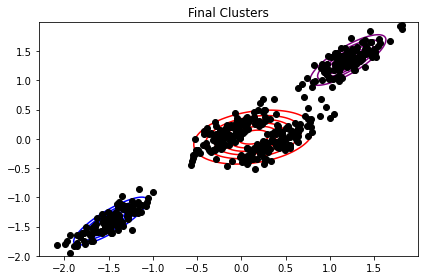

In [15]:
gmm = GaussianMixture(n_components = 3, covariance_type = 'full', 
                      max_iter = 600, random_state = 3)
gmm.fit(dataset)

print('Converged or not: ', gmm.converged_)
print('Means: ', gmm.means_)
print('phi: ', gmm.weights_)

def plot_contours(dataset, means, covs, title):
    plt.figure()
    plt.plot(dataset[:, 0], dataset[:, 1], 'ko')
    delta = 0.01
    k = means.shape[0]
    x = np.arange(-2.0, 2, delta)
    y = np.arange(-2.0, 2, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T
    col = ['blue', 'red', 'purple']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        plt.contour(x_grid, y_grid, z_grid, colors = col[i])
    plt.title(title)
    plt.tight_layout()
plot_contours(dataset, gmm.means_, gmm.covariances_, 'Final Clusters')